In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats
from scipy import linalg

import sys
sys.path.insert(0,'..')
import specsens as ss

Created WidebandSignal with 1.0 MHz total bandwidth and 102400 samples per step


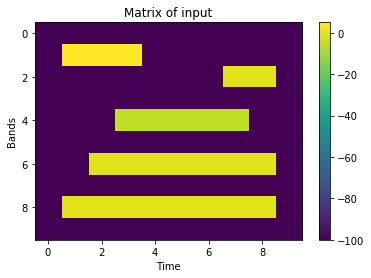

In [124]:
length = 1.024 # in seconds

wbs = ss.WidebandSignal(t_sec=length, num_bands=10, num_steps=10)

# One creates the matrix with the time axis vertical and the bands horizontal.
# Most of the plots below rotate the matrix 90 degree counterclockwise.

# mat = np.array([[-100, -100, -100, -100, -100, -100, -100, -100, -100, -100],
#                 [-100,    0, -100, -100, -100, -100, -100, -100,   10, -100],
#                 [-100,    0, -100,    5, -100, -100, -100, -100,   10, -100],
#                 [-100,    0, -100,    5, -100,   10, -100, -100,   10, -100],
#                 [-100,    0, -100,    5, -100,   10, -100, -100, -100, -100],
#                 [-100,    0, -100,    5, -100,   10, -100, -100, -100, -100],
#                 [-100,    0, -100,    5, -100,   10, -100, -100, -100, -100],
#                 [-100,    0, -100,    5, -100,   10, -100,    5, -100, -100],
#                 [-100,    0, -100,    5, -100, -100, -100,    5, -100, -100],
#                 [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100]])

mat = np.array([[-100, -100, -100, -100, -100, -100, -100, -100, -100, -100],
                [-100,    0, -100, -100, -100, -100, -100, -100,    5, -100],
                [-100,    0, -100,    0, -100, -100, -100, -100,    5, -100],
                [-100,    0, -100,    0, -100,   -5, -100, -100,    5, -100],
                [-100,    0, -100,    0, -100,   -5, -100, -100, -100, -100],
                [-100,    0, -100,    0, -100,   -5, -100, -100, -100, -100],
                [-100,    0, -100,    0, -100,   -5, -100, -100, -100, -100],
                [-100,    0, -100,    0, -100,   -5, -100,    0, -100, -100],
                [-100,    0, -100,    0, -100, -100, -100,    0, -100, -100],
                [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100]])

# Plot the input signal matrix
ss.util_wide.plot_matrix(mat, title='input')

# Create wideband signal
sig, sample_freq = wbs.get_signal(mat)

# Create noise signal
noise_power = -10.
wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length)
noise = wgn.get_signal(power=noise_power, dB=True)

assert wbs.num_samples == wgn.num_samples  # ensure noise and signal have same length
num_samples = wbs.num_samples

both = sig + noise  # create actual signal ('both') comprising of signal and additive white gaussian noise (AWGN)

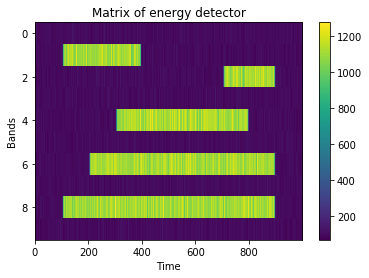

False Alarm: 0.01000
Threshold:   126.95417
Detection:   1.00000


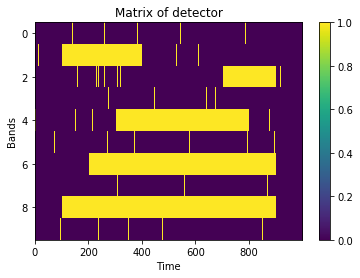

Simulation False Alarm: 0.01587
Simulation Detection:   0.99240


In [34]:
# Use the STFT to transform the signal into the frequency domain
nfft = 1024

sft = ss.Stft(n=nfft, window='box')
f, t, x = sft.spectogram(both, sample_freq, normalized=False, dB=False)

# Create a Frequency Energy Detector object
fed = ss.FreqEnergyDetector(num_bands=10,
                            f_sample=sample_freq,
                            fft_len=nfft,
                            freqs=f)

# Compute the energy at every timestep
res = []
for i in range(len(t)):
    res.append(fed.detect(x[:, i]))
res = np.array(res)

# Plot result of energy detector 
ss.util_wide.plot_matrix(res, title='energy detector')

# Compute threshold and probability of false alarm
pfa = 0.01
thr = ss.chi2_stats.get_thr(noise_power=noise_power,
                            pfa=pfa,
                            n=nfft // 10,
                            dB=True)
pd = ss.chi2_stats.get_pd(noise_power=noise_power,
                           signal_power=0.,
                           thr=thr,
                            n=nfft // 10,
                            dB=True,
                            bands=10)
print('False Alarm: %.5f' % (pfa))
print('Threshold:   %.5f' % (thr))
print('Detection:   %.5f' % (pd))

# Apply threshold to result of energy detector matrix
res = (res > thr) * np.full_like(res, 1.)

ss.util_wide.plot_matrix(res, title='detector')

mats, factor = ss.util_wide.scale_matrix(mat, signal_length=1.024, band_width=1e5, fft_len=nfft)

print('Simulation False Alarm: %.5f' % (ss.util_wide.get_pfa(res, mats)))
print('Simulation Detection:   %.5f' % (ss.util_wide.get_pd(res, mats)))

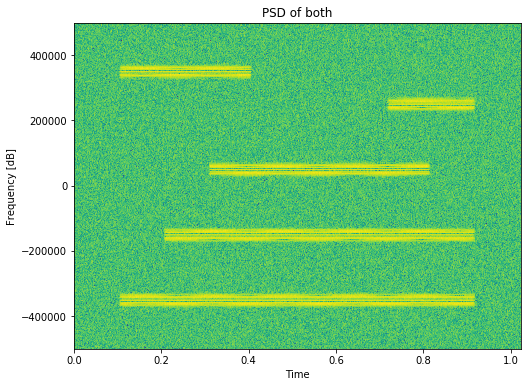

In [35]:
# Plot the wideband signal in 2d
ss.plot2d(both,
          sample_freq,
          window='flattop',
          nfft=1024,
          dB=True,
          type='our',
          title='both')

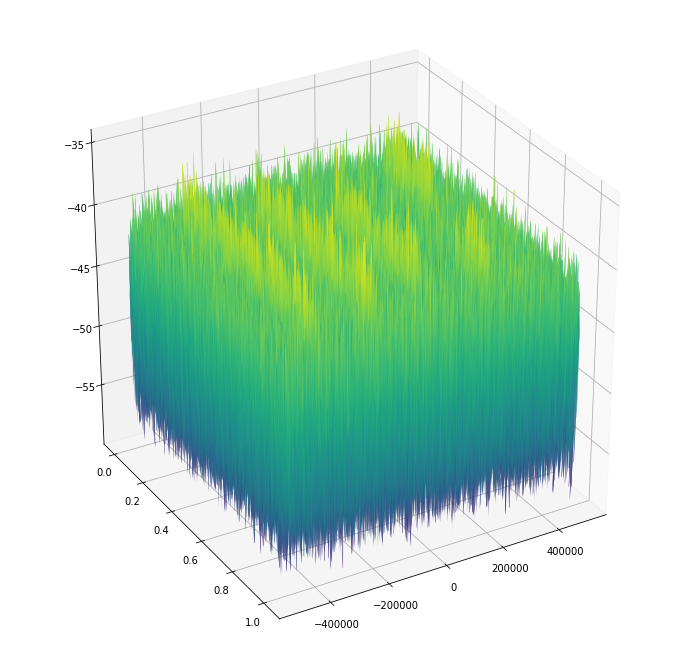

In [8]:
# Plot the wideband signal in 3d
# Use out 3D Plot 
ss.plot3d(sig=both,
          f_sample=sample_freq,
          window='flattop',
          nfft=1024,
          clip=-60,
          smooth=.5,
          crop=None,
          elev=30,
          azim=60,
          type='our')

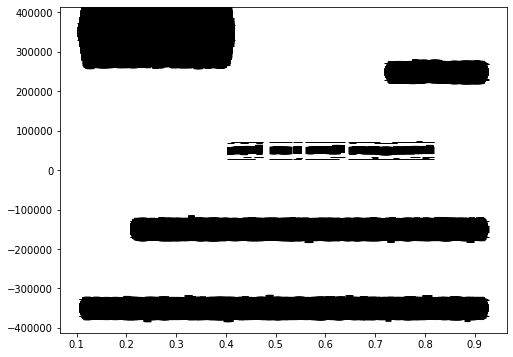

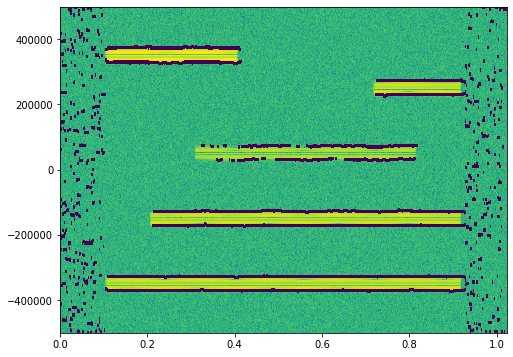

In [127]:
class VariableBandFreqEnergyDetector():
    def __init__(self, f_sample=1e6, fft_len=1024, freqs=None):
        self.f_sample = f_sample  # sample rate used with the
        self.fft_len = fft_len  # length of the fft used to compute the power spectrum
        self.freqs = freqs  # frequency band, x axis, used by the power spectrum
        self.ps_list = np.zeros(shape=(fft_len, 0))
#         self.peak_list = np.zeros(shape=(fft_len, 0))

    def ps_smooth(self, ps):
        if np.size(self.ps_list, 1) >= 10:
            self.ps_list = np.delete(self.ps_list, 0, axis=1)
        self.ps_list = np.concatenate((self.ps_list, np.array([ps]).T), axis=1)
        return np.mean(self.ps_list, axis=1)

    def detect(self, ps):
        ps = self.ps_smooth(ps)
        ps_dB = 10. * np.log10(ps)
        prod, peak, peakf = ss.band_detect(ps_dB,
                                           self.freqs,
                                           scale=5,
                                           min_height=0.2,
                                           min_freq=3e4)
        
#         print(self.energys(peak, ps))
        dics = self.energys(peak, ps)
    
#         print(dics)
#         print('---done---')
        return ps, peak, peakf, dics
    
    def energys(self, peak, ps):
        energ = {}
        if len(peak) == 0:
            return energ
        energ[self.cen(0, peak[0])] = (self.en(ps, 0, peak[0]), 0, peak[0], np.abs(peak[0] - 0))
        for i, _ in enumerate(peak[:-1]):
            energ[self.cen(peak[i], peak[i+1])] = (self.en(ps, peak[i], peak[i+1]), peak[i], peak[i+1], np.abs(peak[i+1] - peak[i]))
        energ[self.cen(peak[-1], len(ps))] = (self.en(ps, peak[-1], len(ps)), peak[-1], len(ps), np.abs(peak[-1] - len(ps)))
        return energ
    
#     def energys(self, peak, ps):
#         energ = np.array([])
#         if len(peak) == 0:
#             return energ
#         energ = np.append(energ, (0, peak[0], self.en(ps, 0, peak[0])))
# #         energ = np.append(energ, (0, peak[0], np.sum(ps[0:peak[0]])))
#         for i, _ in enumerate(peak[:-1]):
# #             print((peak[i], peak[i+1]))
#             energ = np.append(energ, (peak[i], peak[i+1], self.en(ps, i, i+1)))
# #             energ = np.append(energ, (peak[i], peak[i+1], np.sum(ps[i:i+1])))
#             if i == 0: 
#                 print(energ)
#         energ = np.append(energ, (peak[-1], len(ps),  self.en(ps, peak[-1], len(ps))))
# #         energ = np.append(energ, (peak[-1], len(ps),  np.sum(ps[peak[-1]:len(ps)])))
#         return energ
    
    def en(self, ps, start, stop):
        return np.sum(ps[start:stop]) / np.abs(stop-start)
    
    def cen(self, start, stop):
        return start + np.abs(stop-start) / 2.

    
    
sft = ss.Stft(n=1024, window='flattop')
f, t, x = sft.spectogram(both, sample_freq, normalized=False, dB=False)

ved = VariableBandFreqEnergyDetector(f_sample=1e6, fft_len=1024, freqs=f)

res = np.empty(shape=(len(f), len(t)))
res[:] = np.nan


def threshold(v):
    thr = ss.chi2_stats.get_thr(noise_power=noise_power,
                            pfa=pfa,
                            n=v[3],
                            dB=True)
    return v[0] > thr

plt.figure(figsize=(8, 6))
# tupls = np.array([])
for i, _ in enumerate(t):
    ps, peak, peakf, dics = ved.detect(x[:, i])
    res[np.maximum(peak - 3, 0), i] = 1.
    res[np.maximum(peak - 2, 0), i] = 1.
    res[np.maximum(peak - 1, 0), i] = 1.
    res[peak, i] = 1.
    res[np.minimum(peak + 1, len(f)-1), i] = 1.
    res[np.minimum(peak + 2, len(f)-1), i] = 1.
    res[np.minimum(peak + 3, len(f)-1), i] = 1.
    
    dics = {k: v for k, v in dics.items() if threshold(v)}

    for j, d in enumerate(dics.items()):
        plt.plot(t[i], f[int(d[1][1])], 'k_')
        plt.plot(t[i], f[int(d[0])], 'k_', markeredgewidth=d[1][0])
        plt.plot(t[i], f[int(d[1][2])], 'k_')
    
plt.show()

x_dB = 10. * np.log10(x)
plt.figure(figsize=(8, 6))
plt.pcolormesh(t,
           f,
           x_dB,
           shading='flat',
           cmap='viridis',
           snap=True,
           vmin=np.min(x_dB),
           vmax=np.max(x_dB))
    
plt.pcolormesh(t,
           f,
           res,
           shading='flat',
           cmap='viridis',
           snap=True)
plt.show()